# Validation Report: Standalone Registration

Objective:
- Validate `separation.registration` against pre-saved baseline artifacts from the original pipeline.

Data sources:
- `test_input.pkl` (captured standalone execution input)
- `test_output.pkl` (ground-truth output from original pipeline capture)

Critical architecture rule:
- This notebook must not import the original parent library (`suite2p`).
- Validation is performed by replaying standalone code against captured artifacts only.


In [1]:
from __future__ import annotations

import builtins
import importlib
import importlib.util
import json
import pickle
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

if any(name == "suite2p" or name.startswith("suite2p.") for name in sys.modules):
    raise RuntimeError(
        "Architecture rule violation: `suite2p` is already loaded in this kernel. "
        "Restart the kernel and run this notebook from the top."
    )


class BlockSuite2PImports:
    # Block suite2p imports to prevent namespace pollution.
    def __enter__(self):
        self._orig_import = builtins.__import__

        def guarded_import(name, globals=None, locals=None, fromlist=(), level=0):
            if name == "suite2p" or name.startswith("suite2p."):
                raise ImportError(f"Blocked import by architecture rule: {name}")
            return self._orig_import(name, globals, locals, fromlist, level)

        builtins.__import__ = guarded_import
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        builtins.__import__ = self._orig_import


def find_repo_root(start: Path):
    current = start.resolve()
    for candidate in [current, *current.parents]:
        if (candidate / ".git").exists():
            return candidate
    return None


def load_module_from_file(module_name: str, file_path: Path):
    spec = importlib.util.spec_from_file_location(module_name, str(file_path))
    if spec is None or spec.loader is None:
        raise ImportError(f"Failed to create spec for {module_name} from {file_path}")
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module


def import_standalone_helpers(notebook_dir: Path, repo_root):
    try:
        from separation.registration.binary import BinaryFile as _BinaryFile
        from separation.registration.serialization import deserialize_object as _deserialize_object
        return _BinaryFile, _deserialize_object, "standard"
    except Exception:
        pass

    if repo_root is not None:
        repo_root_str = str(repo_root)
        if repo_root_str not in sys.path:
            sys.path.insert(0, repo_root_str)
        try:
            from separation.registration.binary import BinaryFile as _BinaryFile
            from separation.registration.serialization import deserialize_object as _deserialize_object
            return _BinaryFile, _deserialize_object, "repo_root_bootstrap"
        except Exception:
            pass

    package_dir = notebook_dir
    if not (package_dir / "binary.py").exists():
        package_dir = notebook_dir / "separation" / "registration"
    if not (package_dir / "binary.py").exists():
        raise ImportError(
            f"Could not locate standalone registration helper modules near {notebook_dir}."
        )

    binary_mod = load_module_from_file(
        "standalone_registration_binary_local", package_dir / "binary.py"
    )
    serialization_mod = load_module_from_file(
        "standalone_registration_serialization_local", package_dir / "serialization.py"
    )
    return binary_mod.BinaryFile, serialization_mod.deserialize_object, "local_loader"


def import_standalone_package(package_dir: Path, repo_root):
    try:
        module = importlib.import_module("separation.registration")
        return module, "separation.registration", "standard"
    except Exception:
        pass

    if repo_root is not None:
        repo_root_str = str(repo_root)
        if repo_root_str not in sys.path:
            sys.path.insert(0, repo_root_str)
        try:
            module = importlib.import_module("separation.registration")
            return module, "separation.registration", "repo_root_bootstrap"
        except Exception:
            pass

    init_file = package_dir / "__init__.py"
    if not init_file.exists():
        raise FileNotFoundError(f"Standalone package init not found: {init_file}")

    module_name = "standalone_registration_local"
    spec = importlib.util.spec_from_file_location(
        module_name,
        str(init_file),
        submodule_search_locations=[str(package_dir)],
    )
    if spec is None or spec.loader is None:
        raise ImportError(f"Failed to create package spec from {init_file}")
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module, module_name, "local_loader"


notebook_dir = Path.cwd().resolve()
repo_root = find_repo_root(notebook_dir)

BinaryFile, deserialize_object, import_strategy_used = import_standalone_helpers(
    notebook_dir=notebook_dir,
    repo_root=repo_root,
)

architecture_guard_initialized = True
print("Architecture guard initialized.")
print(f"Python {sys.version.split()[0]}")
print(f"notebook_dir={notebook_dir}")
print(f"repo_root={repo_root}")
print(f"helper_import_strategy={import_strategy_used}")


Architecture guard initialized.
Python 3.9.25
notebook_dir=/home/yz/suite2p/separation/registration
repo_root=/home/yz/suite2p
helper_import_strategy=repo_root_bootstrap


In [2]:
artifact_dir_candidates = [
    Path.cwd(),
    Path.cwd() / "separation" / "registration",
]

artifact_dir = None
for candidate in artifact_dir_candidates:
    if (candidate / "test_input.pkl").exists() and (candidate / "test_output.pkl").exists():
        artifact_dir = candidate
        break

if artifact_dir is None:
    raise FileNotFoundError(
        "Could not locate artifacts. Expected both test_input.pkl and test_output.pkl in one of: "
        + ", ".join(str(c) for c in artifact_dir_candidates)
    )

package_dir = artifact_dir

test_input_path = artifact_dir / "test_input.pkl"
test_output_path = artifact_dir / "test_output.pkl"

print(f"artifact_dir:     {artifact_dir}")
print(f"package_dir:      {package_dir}")
print(f"test_input_path:  {test_input_path}")
print(f"test_output_path: {test_output_path}")


artifact_dir:     /home/yz/suite2p/separation/registration
package_dir:      /home/yz/suite2p/separation/registration
test_input_path:  /home/yz/suite2p/separation/registration/test_input.pkl
test_output_path: /home/yz/suite2p/separation/registration/test_output.pkl


In [3]:
with test_input_path.open("rb") as f:
    captured_input_serialized = pickle.load(f)

print("Loaded captured_input_serialized")
print("top-level keys:", sorted(captured_input_serialized.keys()))
print("type summary:")
for key in sorted(captured_input_serialized.keys()):
    value = captured_input_serialized[key]
    if isinstance(value, dict) and "__type__" in value:
        print(f"  - {key}: serialized {value['__type__']}")
    else:
        print(f"  - {key}: {type(value).__name__}")


Loaded captured_input_serialized
top-level keys: ['align_by_chan2', 'aspect', 'badframes', 'device', 'f_raw', 'f_raw_chan2', 'f_reg', 'f_reg_chan2', 'refImg', 'save_path', 'settings']
type summary:
  - align_by_chan2: bool
  - aspect: float
  - badframes: serialized ndarray
  - device: serialized torch_device
  - f_raw: serialized binary_file
  - f_raw_chan2: NoneType
  - f_reg: serialized binary_file
  - f_reg_chan2: NoneType
  - refImg: NoneType
  - save_path: str
  - settings: dict


In [4]:
with test_output_path.open("rb") as f:
    expected_output_serialized = pickle.load(f)

print("Loaded expected_output_serialized")
print("top-level keys:", sorted(expected_output_serialized.keys()))
print("type summary:")
for key in sorted(expected_output_serialized.keys()):
    value = expected_output_serialized[key]
    if isinstance(value, dict) and "__type__" in value:
        print(f"  - {key}: serialized {value['__type__']}")
    else:
        print(f"  - {key}: {type(value).__name__}")


Loaded expected_output_serialized
top-level keys: ['badframes', 'badframes0', 'bidiphase', 'corrXY', 'corrXY1', 'meanImg', 'meanImgE', 'refImg', 'rmax', 'rmin', 'xoff', 'xoff1', 'xrange', 'yoff', 'yoff1', 'yrange']
type summary:
  - badframes: serialized ndarray
  - badframes0: serialized ndarray
  - bidiphase: float
  - corrXY: serialized ndarray
  - corrXY1: serialized ndarray
  - meanImg: serialized ndarray
  - meanImgE: serialized ndarray
  - refImg: serialized ndarray
  - rmax: serialized numpy_scalar
  - rmin: serialized numpy_scalar
  - xoff: serialized ndarray
  - xoff1: serialized ndarray
  - xrange: list
  - yoff: serialized ndarray
  - yoff1: serialized ndarray
  - yrange: list


In [5]:
opened_binary_handles = []

def build_binary_file(desc):
    required = ("filename", "Ly", "Lx", "n_frames", "dtype", "write")
    missing = [key for key in required if key not in desc]
    if missing:
        raise ValueError(f"Binary descriptor missing keys {missing}: {desc}")

    filename = Path(desc["filename"])
    if not filename.exists():
        raise FileNotFoundError(f"Binary file not found: {filename}")

    bf = BinaryFile(
        Ly=int(desc["Ly"]),
        Lx=int(desc["Lx"]),
        filename=str(filename),
        n_frames=int(desc["n_frames"]),
        dtype=str(desc["dtype"]),
        write=bool(desc["write"]),
    )
    opened_binary_handles.append(bf)
    return bf

kwargs = deserialize_object(
    captured_input_serialized,
    binary_file_factory=build_binary_file,
)
expected_output = deserialize_object(expected_output_serialized)

print("Deserialized kwargs keys:", sorted(kwargs.keys()))
print("Deserialized expected_output keys:", sorted(expected_output.keys()))


Deserialized kwargs keys: ['align_by_chan2', 'aspect', 'badframes', 'device', 'f_raw', 'f_raw_chan2', 'f_reg', 'f_reg_chan2', 'refImg', 'save_path', 'settings']
Deserialized expected_output keys: ['badframes', 'badframes0', 'bidiphase', 'corrXY', 'corrXY1', 'meanImg', 'meanImgE', 'refImg', 'rmax', 'rmin', 'xoff', 'xoff1', 'xrange', 'yoff', 'yoff1', 'yrange']


In [6]:
if "f_reg" not in kwargs:
    raise KeyError("Expected `f_reg` in kwargs for frame snapshot.")

FRAME_INDEX = min(kwargs["f_reg"].n_frames // 2, kwargs["f_reg"].n_frames - 1)
original_frame_snapshot = kwargs["f_reg"][FRAME_INDEX].copy()

print(f"FRAME_INDEX={FRAME_INDEX}")
print(
    "original_frame_snapshot:",
    original_frame_snapshot.shape,
    original_frame_snapshot.dtype,
)


FRAME_INDEX=100
original_frame_snapshot: (662, 788) int16


In [7]:
new_output = None
standalone_frame_snapshot = None
architecture_guard_status = False
standalone_package_name = None
package_import_strategy = None

try:
    with BlockSuite2PImports():
        standalone_module, standalone_package_name, package_import_strategy = import_standalone_package(
            package_dir=package_dir,
            repo_root=repo_root,
        )
        architecture_guard_status = True
        new_output = standalone_module.registration_wrapper(**kwargs)

    standalone_frame_snapshot = kwargs["f_reg"][FRAME_INDEX].copy()

    print("Standalone execution completed.")
    print(f"standalone_package_name={standalone_package_name}")
    print(f"package_import_strategy={package_import_strategy}")
    print("new_output keys:", sorted(new_output.keys()))
finally:
    for bf in opened_binary_handles:
        try:
            bf.close()
        except Exception as exc:
            print(f"Warning: failed to close binary handle {getattr(bf, 'filename', '<unknown>')}: {exc}")


/home/yz/suite2p/separation/registration/register.py:571: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  fr_torch = torch.from_numpy(frames).to(device)


Standalone execution completed.
standalone_package_name=separation.registration
package_import_strategy=standard
new_output keys: ['badframes', 'badframes0', 'bidiphase', 'corrXY', 'corrXY1', 'meanImg', 'meanImgE', 'refImg', 'rmax', 'rmin', 'xoff', 'xoff1', 'xrange', 'yoff', 'yoff1', 'yrange']


In [8]:
comparison_rows = []

def add_row(path, kind, expected, actual, passed, detail, max_abs_error=None):
    shape_expected = tuple(expected.shape) if isinstance(expected, np.ndarray) else None
    shape_actual = tuple(actual.shape) if isinstance(actual, np.ndarray) else None
    comparison_rows.append(
        {
            "path": path,
            "kind": kind,
            "shape_expected": shape_expected,
            "shape_actual": shape_actual,
            "pass": bool(passed),
            "max_abs_error": max_abs_error,
            "detail": detail,
        }
    )

def compare_objects(expected, actual, path="root"):
    if isinstance(expected, dict):
        if not isinstance(actual, dict):
            add_row(path, "dict", expected, actual, False, f"type mismatch: expected dict, got {type(actual).__name__}")
            return

        expected_keys = set(expected.keys())
        actual_keys = set(actual.keys())
        if expected_keys != actual_keys:
            missing = sorted(expected_keys - actual_keys)
            extra = sorted(actual_keys - expected_keys)
            add_row(
                path,
                "dict_keys",
                expected,
                actual,
                False,
                f"key mismatch; missing={missing}, extra={extra}",
            )

        for key in sorted(expected_keys & actual_keys):
            compare_objects(expected[key], actual[key], path=f"{path}.{key}")
        return

    if isinstance(expected, tuple):
        if not isinstance(actual, tuple):
            add_row(path, "tuple", expected, actual, False, f"type mismatch: expected tuple, got {type(actual).__name__}")
            return
        if len(expected) != len(actual):
            add_row(path, "tuple_len", expected, actual, False, f"length mismatch: {len(expected)} != {len(actual)}")
        for idx, (exp_item, act_item) in enumerate(zip(expected, actual)):
            compare_objects(exp_item, act_item, path=f"{path}[{idx}]")
        return

    if isinstance(expected, list):
        if not isinstance(actual, list):
            add_row(path, "list", expected, actual, False, f"type mismatch: expected list, got {type(actual).__name__}")
            return
        if len(expected) != len(actual):
            add_row(path, "list_len", expected, actual, False, f"length mismatch: {len(expected)} != {len(actual)}")
        for idx, (exp_item, act_item) in enumerate(zip(expected, actual)):
            compare_objects(exp_item, act_item, path=f"{path}[{idx}]")
        return

    if isinstance(expected, np.ndarray):
        if not isinstance(actual, np.ndarray):
            add_row(path, "ndarray", expected, actual, False, f"type mismatch: expected ndarray, got {type(actual).__name__}")
            return

        if expected.dtype != actual.dtype:
            add_row(path, "ndarray_dtype", expected, actual, False, f"dtype mismatch: {expected.dtype} != {actual.dtype}")
            return

        if expected.shape != actual.shape:
            add_row(path, "ndarray_shape", expected, actual, False, f"shape mismatch: {expected.shape} != {actual.shape}")
            return

        if np.issubdtype(expected.dtype, np.floating):
            diff = np.abs(expected.astype(np.float64) - actual.astype(np.float64))
            max_abs_error = float(np.nanmax(diff)) if diff.size else 0.0
            try:
                np.testing.assert_allclose(expected, actual, rtol=0.0, atol=0.0, equal_nan=True)
                add_row(path, "ndarray_float", expected, actual, True, "exact float match", max_abs_error=max_abs_error)
            except AssertionError as exc:
                add_row(path, "ndarray_float", expected, actual, False, str(exc).splitlines()[0], max_abs_error=max_abs_error)
        else:
            passed = bool(np.array_equal(expected, actual))
            add_row(
                path,
                "ndarray_exact",
                expected,
                actual,
                passed,
                "exact array match" if passed else "array values differ",
                max_abs_error=None,
            )
        return

    if type(expected) is not type(actual):
        add_row(path, "scalar_type", expected, actual, False, f"type mismatch: {type(expected).__name__} != {type(actual).__name__}")
        return

    passed = expected == actual
    add_row(path, "scalar", expected, actual, passed, "exact scalar match" if passed else f"value mismatch: {expected!r} != {actual!r}")

compare_objects(expected_output, new_output)

failed_rows = [row for row in comparison_rows if not row["pass"]]
overall_pass = len(failed_rows) == 0

print(f"Total checks: {len(comparison_rows)}")
print(f"Passed: {len(comparison_rows) - len(failed_rows)}")
print(f"Failed: {len(failed_rows)}")
print(f"Overall PASS: {overall_pass}")

print("\nPer-key report (top-level expected output keys):")
top_level_report = {}
for key in sorted(expected_output.keys()):
    prefix = f"root.{key}"
    rows = [
        row for row in comparison_rows
        if row["path"] == prefix or row["path"].startswith(prefix + ".") or row["path"].startswith(prefix + "[")
    ]
    key_pass = bool(rows) and all(row["pass"] for row in rows)
    float_errors = [row["max_abs_error"] for row in rows if row["max_abs_error"] is not None]
    max_abs_error = max(float_errors) if float_errors else None
    top_level_report[key] = {
        "pass": key_pass,
        "max_abs_error": max_abs_error,
        "n_checks": len(rows),
    }
    print(f"  - {key:10s} PASS={key_pass} max_abs_error={max_abs_error} n_checks={len(rows)}")

if failed_rows:
    print("\nFailed rows:")
    for row in failed_rows:
        print(
            f"  - {row['path']} | kind={row['kind']} | "
            f"max_abs_error={row['max_abs_error']} | detail={row['detail']}"
        )


Total checks: 18
Passed: 18
Failed: 0
Overall PASS: True

Per-key report (top-level expected output keys):
  - badframes  PASS=True max_abs_error=None n_checks=1
  - badframes0 PASS=True max_abs_error=None n_checks=1
  - bidiphase  PASS=True max_abs_error=None n_checks=1
  - corrXY     PASS=True max_abs_error=0.0 n_checks=1
  - corrXY1    PASS=True max_abs_error=0.0 n_checks=1
  - meanImg    PASS=True max_abs_error=0.0 n_checks=1
  - meanImgE   PASS=True max_abs_error=0.0 n_checks=1
  - refImg     PASS=True max_abs_error=None n_checks=1
  - rmax       PASS=True max_abs_error=None n_checks=1
  - rmin       PASS=True max_abs_error=None n_checks=1
  - xoff       PASS=True max_abs_error=None n_checks=1
  - xoff1      PASS=True max_abs_error=0.0 n_checks=1
  - xrange     PASS=True max_abs_error=None n_checks=2
  - yoff       PASS=True max_abs_error=None n_checks=1
  - yoff1      PASS=True max_abs_error=0.0 n_checks=1
  - yrange     PASS=True max_abs_error=None n_checks=2


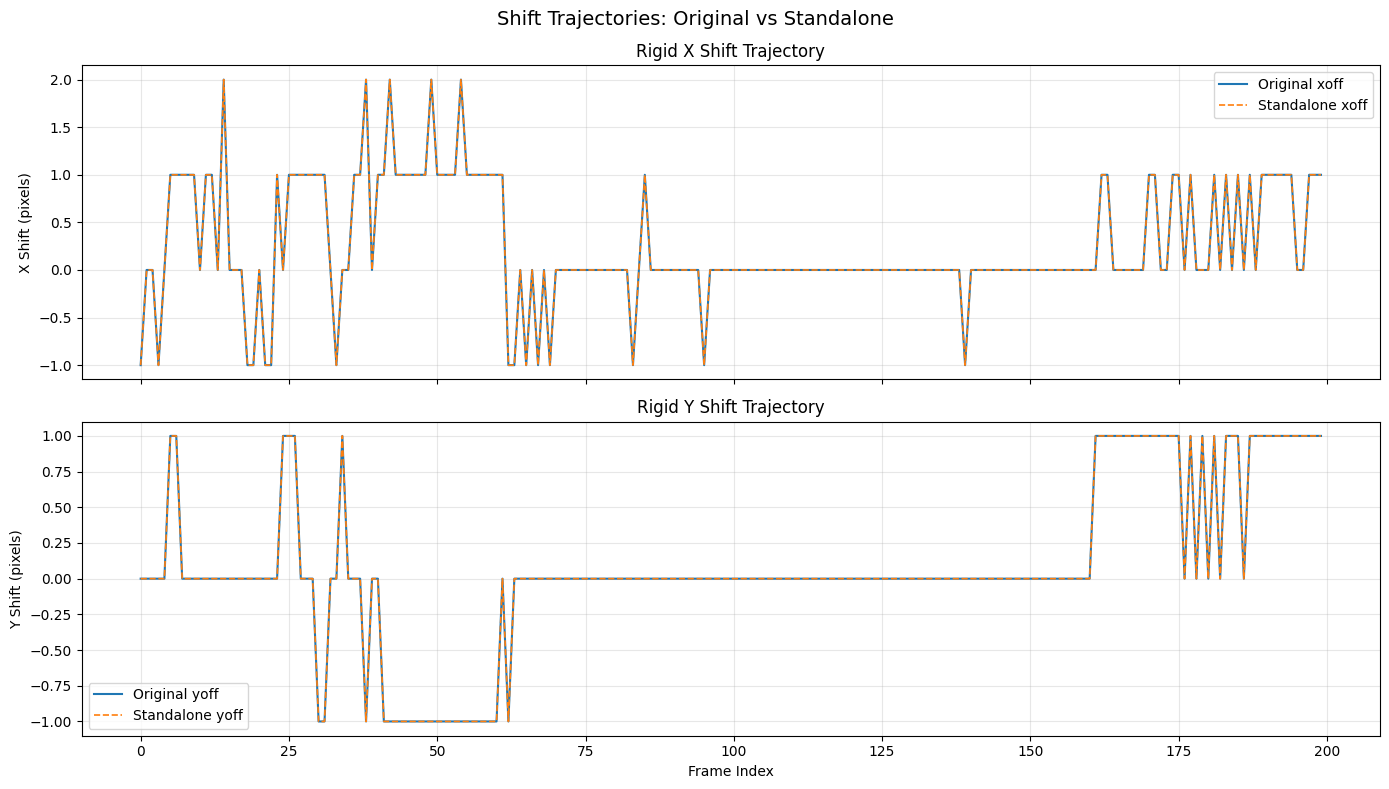

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

axes[0].plot(expected_output["xoff"], label="Original xoff", linewidth=1.5)
axes[0].plot(new_output["xoff"], label="Standalone xoff", linestyle="--", linewidth=1.2)
axes[0].set_ylabel("X Shift (pixels)")
axes[0].set_title("Rigid X Shift Trajectory")
axes[0].grid(alpha=0.3)
axes[0].legend()

axes[1].plot(expected_output["yoff"], label="Original yoff", linewidth=1.5)
axes[1].plot(new_output["yoff"], label="Standalone yoff", linestyle="--", linewidth=1.2)
axes[1].set_xlabel("Frame Index")
axes[1].set_ylabel("Y Shift (pixels)")
axes[1].set_title("Rigid Y Shift Trajectory")
axes[1].grid(alpha=0.3)
axes[1].legend()

fig.suptitle("Shift Trajectories: Original vs Standalone", fontsize=14)
plt.tight_layout()
plt.show()


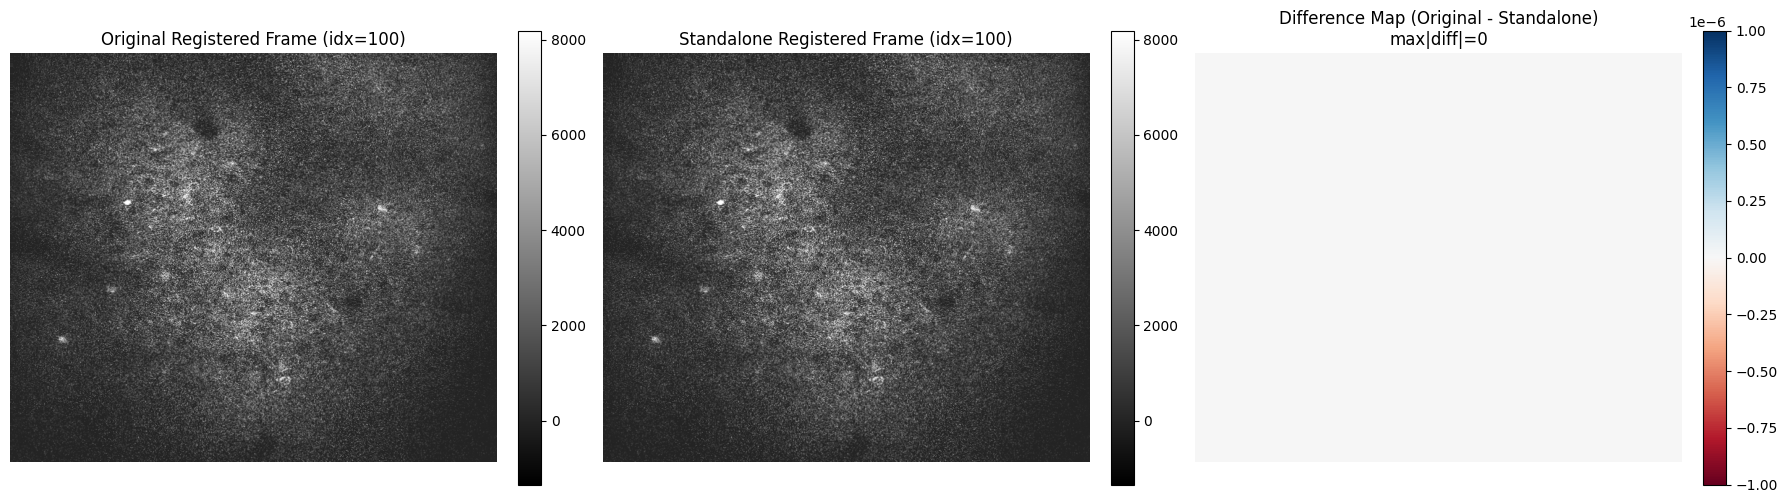

In [10]:
frame_diff = (
    original_frame_snapshot.astype(np.float32)
    - standalone_frame_snapshot.astype(np.float32)
)
frame_diff_max = float(np.max(np.abs(frame_diff)))

vlim = frame_diff_max if frame_diff_max > 0 else 1e-6

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

im0 = axes[0].imshow(original_frame_snapshot, cmap="gray")
axes[0].set_title(f"Original Registered Frame (idx={FRAME_INDEX})")
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(standalone_frame_snapshot, cmap="gray")
axes[1].set_title(f"Standalone Registered Frame (idx={FRAME_INDEX})")
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(frame_diff, cmap="RdBu", vmin=-vlim, vmax=vlim)
axes[2].set_title(f"Difference Map (Original - Standalone)\nmax|diff|={frame_diff_max:.6g}")
axes[2].axis("off")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [11]:
float_error_values = [row["max_abs_error"] for row in comparison_rows if row["max_abs_error"] is not None]
global_max_float_error = max(float_error_values) if float_error_values else 0.0

mismatched_top_level = [key for key, info in top_level_report.items() if not info["pass"]]

print("Final Summary")
print("=============")
print(f"Architecture guard initialized: {architecture_guard_initialized}")
print(f"Architecture guard active during execution: {architecture_guard_status}")
print(f"Helper import strategy: {import_strategy_used}")
print(f"Package import strategy: {package_import_strategy}")
print(f"Standalone package name: {standalone_package_name}")
print(f"Overall strict comparison PASS: {overall_pass}")
print(f"Mismatched top-level keys: {len(mismatched_top_level)}")
if mismatched_top_level:
    print(f"Top-level mismatches: {mismatched_top_level}")
print(f"Global max absolute float error: {global_max_float_error}")
print(f"Frame-level max absolute diff: {frame_diff_max}")


Final Summary
Architecture guard initialized: True
Architecture guard active during execution: True
Helper import strategy: repo_root_bootstrap
Package import strategy: standard
Standalone package name: separation.registration
Overall strict comparison PASS: True
Mismatched top-level keys: 0
Global max absolute float error: 0.0
Frame-level max absolute diff: 0.0
